## Get a frame stream from a merlin detector

This notebook shows how you can access the stream of frames from a Merlin Medipix detector, without using the high-level features of LiberTEM, like user-defined functions (UDFs). You get access to the data in a chunked fashion, that is, you'll always get a small frame stack to work on.

### Usage with the simulator
If you want to use this with the simulated data source, run something like this in the background:

`libertem-live-mib-sim ~/Data/default.hdr --cached=MEM --wait-trigger`

The `--wait-trigger` option is important for this notebook to function correctly, to properly model the real behavior.

A suitable MIB dataset can be downloaded at https://zenodo.org/record/5113449.

On Linux, `MEMFD` is also supported as a cache. Use `NONE` to deactivate the cache.

In [1]:
# set to info, debug or trace to get more detailed logging:
%env LIBERTEM_QD_LOG_LEVEL=error

env: LIBERTEM_QD_LOG_LEVEL=error


In [2]:
# set this to the host/port where the merlin data server is listening:
MERLIN_DATA_SOCKET = ('127.0.0.1', 6342)
MERLIN_CONTROL_SOCKET = ('127.0.0.1', 6341)

In [3]:
%matplotlib widget

In [4]:
import time
import math
import os
import tempfile
import logging
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from libertem_qd_mpx import QdConnection, CamClient
from libertem_live.detectors.merlin import MerlinControl

In [6]:
def make_socket_path():
    temp_path = tempfile.mkdtemp()
    return os.path.join(temp_path, 'qd-shm-socket')

In [7]:
socket_path = make_socket_path()

In [8]:
conn = QdConnection(
    data_host=MERLIN_DATA_SOCKET[0],
    data_port=MERLIN_DATA_SOCKET[1],
    frame_stack_size=16,
    shm_handle_path=socket_path,
    drain=False,
    recovery_strategy="immediate_reconnect",
    huge=False,
)
control = MerlinControl(host=MERLIN_CONTROL_SOCKET[0], port=MERLIN_CONTROL_SOCKET[1])

In [9]:
# start the background thread:
conn.start_passive()

In [10]:
cam_client = CamClient(handle_path=socket_path)

In [11]:
# connect the control socket, and close after the block automatically:
with control:
    # Tell the detector to send us some data:
    # (in a real setup, you probably want to properly configure triggering,
    # or even start the microscope scan here)
    control.cmd('STARTACQUISITION')
    control.cmd('SOFTTRIGGER')

    # wait for an acquisition to start, with a timeout
    # (as we just triggered one above, this should succeed immediately):
    header = conn.wait_for_arm(timeout=10.0)
    assert header is not None
    print(header.frames_in_acquisition())

    # current frame temp. buffer (needs to be 3D to work with `decode_range_into_buffer`):
    current_frames = np.zeros((16,) + header.detector_shape(), dtype=np.float32)

    # results
    result = np.zeros(header.detector_shape(), dtype=np.float32)
    result_nav = np.zeros((header.frames_in_acquisition(),), dtype=np.float32)
    
    index = 0

    # get the data as stacks of frames:
    while True:
        frame_stack = conn.get_next_stack(max_size=16)
        try:
            # decode the whole stack:
            cam_client.decode_range_into_buffer(
                frame_stack,
                current_frames,
                0,
                len(frame_stack),
            )
            result += current_frames[:len(frame_stack)].sum(axis=0)
            result_nav[index:index+len(frame_stack)] = current_frames[:len(frame_stack)].sum(axis=(1, 2))

            index += len(frame_stack)

            # are we done yet?
            if index == np.prod(result_nav.shape):
                print("done!")
                break
        finally:
            # free up space in the shared memory area:
            cam_client.done(frame_stack)

16384
done!


In [12]:
# close both the cam client and the connection:
cam_client.close()
conn.close()

In [13]:
# assuming a square scan:
side = int(math.sqrt(header.frames_in_acquisition()))
side

128

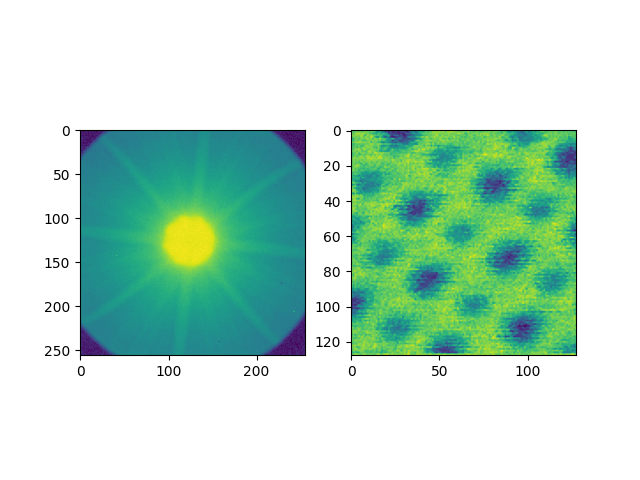

In [14]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.log1p(result))
axes[1].imshow(np.log1p(result_nav.reshape((side, side))))